Trained the Deep learning model to Predict presence of Hepatitis C and its progress 


In [ ]:
#loaded required packages
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import confusion_matrix
%tensorflow_version 2.x
from numpy.random import seed
seed(2)
import tensorflow as tf
from tensorflow import keras
from IPython import display
from matplotlib import cm
from matplotlib import gridspec
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
from tensorflow.python.data import Dataset
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn import metrics
from pandas import read_csv
from imblearn.over_sampling import SMOTE
from collections import Counter
from matplotlib import pyplot
from sklearn.preprocessing import LabelEncoder
print(tf.__version__)

/usr/local/lib/python3.6/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)


2.3.0


/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)


# Preprocessing

In [ ]:

# define the dataset location
url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/00571/hcvdat0.csv'
# load the csv file as a data frame
df = read_csv(url)


In [ ]:
df.head()

,Unnamed: 0,Category,Age,Sex,ALB,ALP,ALT,AST,BIL,CHE,CHOL,CREA,GGT,PROT
0,1,0=Blood Donor,32,m,38.5,52.5,7.7,22.1,7.5,6.93,3.23,106.0,12.1,69.0
1,2,0=Blood Donor,32,m,38.5,70.3,18.0,24.7,3.9,11.17,4.80,74.0,15.6,76.5
2,3,0=Blood Donor,32,m,46.9,74.7,36.2,52.6,6.1,8.84,5.20,86.0,33.2,79.3
3,4,0=Blood Donor,32,m,43.2,52.0,30.6,22.6,18.9,7.33,4.74,80.0,33.8,75.7
4,5,0=Blood Donor,32,m,39.2,74.1,32.6,24.8,9.6,9.15,4.32,76.0,29.9,68.7


In [ ]:
df.isnull().sum()

Unnamed: 0     0
Category       0
Age            0
Sex            0
ALB            1
ALP           18
ALT            1
AST            0
BIL            0
CHE            0
CHOL          10
CREA           0
GGT            0
PROT           1
dtype: int64

In [ ]:
enc = OneHotEncoder(handle_unknown='ignore')
enc_df = pd.DataFrame(enc.fit_transform(df[['Sex']] ).toarray())


In [ ]:
enc_df.rename({1:'Male',0:'Female'}, axis=1, inplace=True)

In [ ]:
df = df.join(enc_df)

In [ ]:
del df["Sex"]

In [ ]:
del df['Unnamed: 0']

In [ ]:
for i in df.columns[df.isnull().any(axis=0)]:
  df[i].fillna(df[i].mean(),inplace = True)


In [ ]:
df['Category'].value_counts()

0=Blood Donor             533
3=Cirrhosis                30
1=Hepatitis                24
2=Fibrosis                 21
0s=suspect Blood Donor      7
Name: Category, dtype: int64

In [ ]:
data = df.values
# split into input and output elements
X, y = df.drop(columns=['Category'],inplace=False), df['Category']
y=pd.DataFrame(y, columns=['Category'])

In [ ]:
from sklearn.model_selection import train_test_split
x_train,x_test,y_train,y_test=train_test_split(X,y,test_size=0.2,random_state=42)
scaler = StandardScaler().fit(x_train.values)
scaledf = scaler.transform(x_train.values)
x_train = pd.DataFrame(scaledf, index=x_train.index, columns=x_train.columns)
vscaled = scaler.transform(x_test.values)
x_test= pd.DataFrame(vscaled, index=x_test.index, columns=x_test.columns)

In [ ]:
x_train

,Age,ALB,ALP,ALT,AST,BIL,CHE,CHOL,CREA,GGT,PROT,Female,Male
83,-0.835559,-0.901069,0.161813,0.027689,-0.257913,-0.280688,-1.157568,-0.638987,-0.080611,-0.322796,-1.056130,-0.855800,0.855800
90,-0.835559,0.726659,-0.254815,-0.320797,-0.346239,1.817927,0.219224,-0.536210,-0.080611,-0.486144,0.667928,-0.855800,0.855800
228,0.591500,0.496654,-0.316362,-0.588536,-0.480152,-0.179486,-0.566162,-0.347786,-0.208413,-0.427632,0.012036,-0.855800,0.855800
509,1.101164,-2.723417,-0.728255,0.478170,1.203739,-0.296667,-1.417786,-1.606802,-0.756136,-0.113126,-3.923313,1.168497,-1.168497
329,-1.447156,0.125108,3.281786,-0.597035,-0.622613,-0.424502,0.039437,-0.032518,-0.610077,-0.247217,0.461790,1.168497,-1.168497
...,...,...,...,...,...,...,...,...,...,...,...,...,...
71,-0.937492,-0.317210,-0.235877,1.846613,0.254948,-0.051651,1.302678,1.373727,0.321053,1.278990,0.218173,-0.855800,0.855800
106,-0.631693,0.532040,0.332251,-0.129555,-0.420318,-0.270035,1.037729,-1.007270,-0.135383,-0.295978,0.030776,-0.855800,0.855800
270,1.203097,-0.334903,-0.875022,-0.121055,-0.386128,0.710029,-0.305944,-1.469766,0.083706,-0.417880,-0.006704,-0.855800,0.855800
435,0.081836,0.478961,-0.728255,-0.503539,-0.329143,-0.365911,0.432130,1.176738,-0.135383,-0.622674,0.218173,1.168497,-1.168497


#**OverSampling of training data**

Class=0, n=437 (20.000%)
Class=3, n=437 (20.000%)
Class=4, n=437 (20.000%)
Class=2, n=437 (20.000%)
Class=1, n=437 (20.000%)


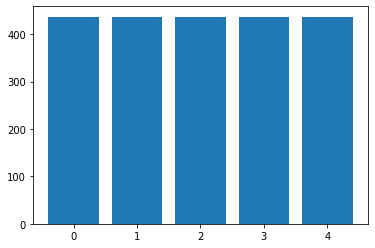

In [ ]:
y_train = LabelEncoder().fit_transform(y_train)
y_test = LabelEncoder().fit_transform(y_test)
# transform the dataset

oversample=SMOTE(kind='regular',k_neighbors=2)
x_train, y_train = oversample.fit_resample(x_train, y_train)
# summarize distribution
counter = Counter(y_train)
for k,v in counter.items():
	per = v / len(y_train) * 100
	print('Class=%d, n=%d (%.3f%%)' % (k, v, per))
# plot the distribution
pyplot.bar(counter.keys(), counter.values())
pyplot.show()

In [ ]:
nb_classes = 5
targets = y_train.reshape(-1)
targets1 = y_test.reshape(-1)
y_train = np.eye(nb_classes)[targets]
y_test = np.eye(nb_classes)[targets1]

# Modelling

In [ ]:
METRICS = [
      keras.metrics.TruePositives(name='tp'),
      keras.metrics.FalsePositives(name='fp'),
      keras.metrics.TrueNegatives(name='tn'),
      keras.metrics.FalseNegatives(name='fn'), 
      keras.metrics.BinaryAccuracy(name='accuracy'),
      keras.metrics.Precision(name='precision'),
      keras.metrics.Recall(name='recall'),
      keras.metrics.AUC(name='auc'),
]

baseline_model = keras.Sequential([
    keras.layers.Dense(8, activation=tf.nn.relu,
                       input_shape=(x_train.shape[1],)),
    keras.layers.Dense(5, activation = tf.nn.softmax)

  ])

baseline_model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=METRICS)

baseline_model.summary()




Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 8)                 112       
_________________________________________________________________
dense_1 (Dense)              (None, 5)                 45        
Total params: 157
Trainable params: 157
Non-trainable params: 0
_________________________________________________________________


In [ ]:
class PrintDot(keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs):
    if epoch % 100 == 0: print('')
    print('.', end='')

EPOCHS =500
b_history = baseline_model.fit(x_train, y_train, epochs=EPOCHS,batch_size=128,
                    validation_data= (x_test, y_test), verbose=0,
                    callbacks=[PrintDot()])


....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................

In [ ]:
print(max(b_history.history['val_accuracy']))
print(max(b_history.history['val_recall']))

0.9593495726585388
0.8943089246749878


In [ ]:
valpreds = baseline_model.predict_on_batch(x_test)
y_pred = valpreds.argmax(axis=1)
y_pred= pd.DataFrame(y_pred,columns=["progress"])
y_pred['progress'].value_counts()

0    100
2     10
3      7
4      4
1      2
Name: progress, dtype: int64

In [ ]:
y_test1 = y_test.argmax(axis=1)
y_test1= pd.DataFrame(y_test1,columns=["progress"])


In [ ]:
print(metrics.confusion_matrix(y_test1,y_pred))
print(metrics.classification_report(y_test1,y_pred))

[[93  0  3  0  0]
 [ 1  2  0  0  0]
 [ 2  0  6  1  0]
 [ 2  0  0  4  0]
 [ 2  0  1  2  4]]
              precision    recall  f1-score   support

           0       0.93      0.97      0.95        96
           1       1.00      0.67      0.80         3
           2       0.60      0.67      0.63         9
           3       0.57      0.67      0.62         6
           4       1.00      0.44      0.62         9

    accuracy                           0.89       123
   macro avg       0.82      0.68      0.72       123
weighted avg       0.90      0.89      0.88       123



Text(200, 0.7, 'Baseline Performance')

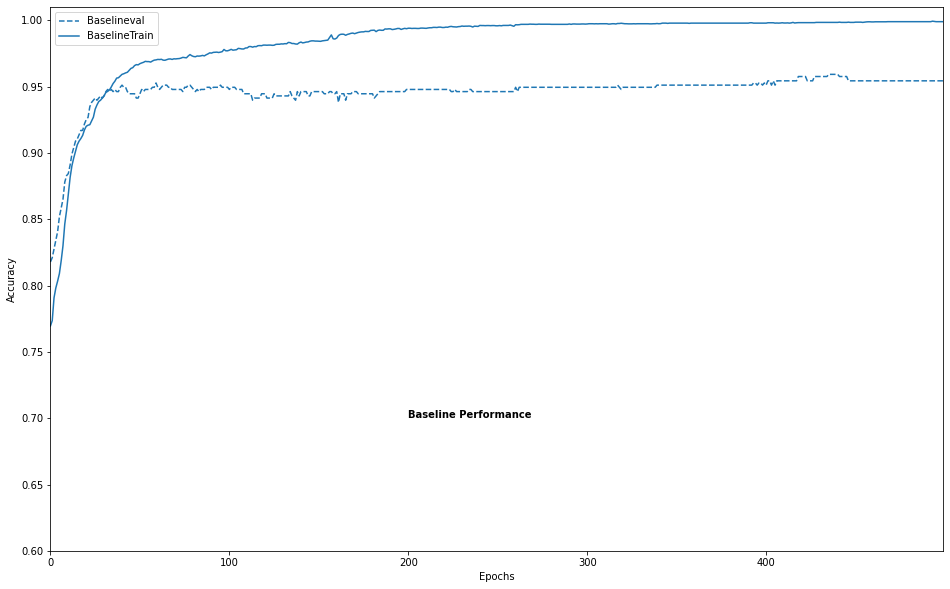

In [ ]:
import matplotlib.pyplot as plt
def plot_history(histories, key):
  plt.figure(figsize=(16,10))
  for name, history in histories:
    val = plt.plot(history.epoch, history.history['val_'+key],
                   '--', label = name.title()+ 'val')
    plt.plot(history.epoch,history.history[key], color=val[0].get_color(),
             label =name.title()+'Train')
    plt.xlabel('Epochs')
    plt.ylabel(key.replace('_','').title())
    plt.legend()
    

    plt.xlim([0,max(history.epoch)])
    plt.ylim([0.6,1.01])
plot_history([('baseline', b_history)],'accuracy')
plt.annotate('Baseline Performance',xy=(200,0.7),weight='bold')

#Analysis of Model

1. Before oversampling I have trained the baseline model and obtained accuarcy of  93 pecent, recall 82 percent but most of the records were predicted as Class '0:Blood Donor' but our model aim is to predict the presence of Hepatitis C and its progress . So done the oversampling for training data getting the balanced classes.
2. After oversampling , trained the model with 500 Epochs and got an accuracy of 95.9 and recall 89.4 . From the confusion matrix above we can see the prediction of target label in all the classes.
3. Though the records are less for classes(2,3,4) which indicates the presence of Hepatitis C and its progress, got pretty good recall rates for the model after oversampling.
4. The naive accuracy(baseline performance) without training any model is approximately 88.8 percent for training data. The baseline model trained  above is far better than the naive accuracy as we got pretty good recall and accuracy.

** 2 Hidden layers**

In [ ]:
hidden2_model = keras.Sequential([
    keras.layers.Dense(8, activation=tf.nn.relu,
                       input_shape=(x_train.shape[1],)),
    keras.layers.Dense(8, activation=tf.nn.relu),
    keras.layers.Dense(5, activation = tf.nn.softmax)

  ])

hidden2_model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=METRICS)

hidden2_model.summary()
hidden2_history = hidden2_model.fit(x_train, y_train, epochs=EPOCHS,batch_size=128,
                    validation_data= (x_test, y_test), verbose=0,
                    callbacks=[PrintDot()])
print('\n')
print(max(hidden2_history.history['val_accuracy']))


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2 (Dense)              (None, 8)                 112       
_________________________________________________________________
dense_3 (Dense)              (None, 8)                 72        
_________________________________________________________________
dense_4 (Dense)              (None, 5)                 45        
Total params: 229
Trainable params: 229
Non-trainable params: 0
_________________________________________________________________

....................................................................................................
....................................................................................................
....................................................................................................
..................................................................................

In [ ]:
print(max(b_history.history['val_recall']))
print(max(hidden2_history.history['val_recall']))

0.8943089246749878
0.8455284833908081


Text(200, 0.7, 'one hidden layer Vs two hidden layers')

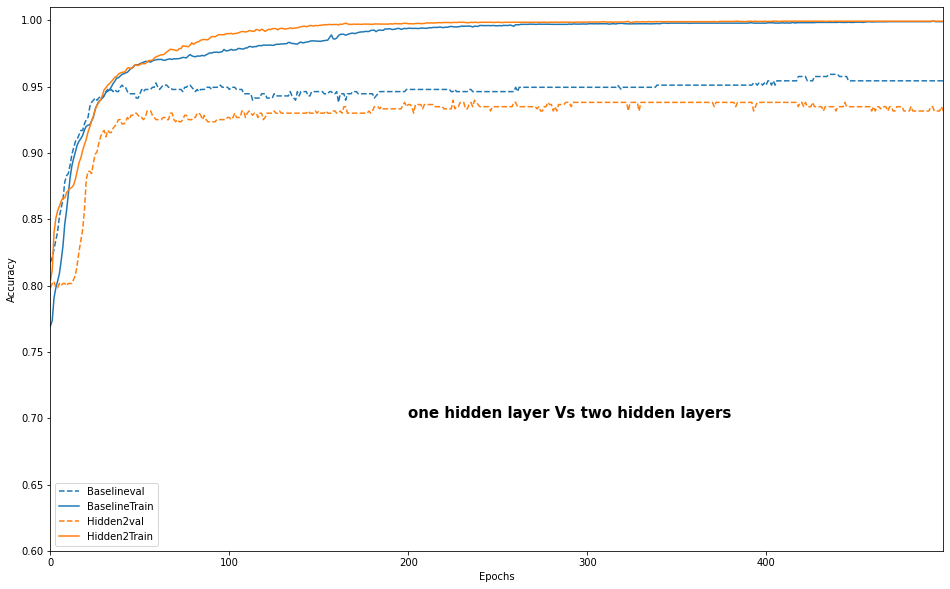

In [ ]:
plot_history([('baseline', b_history),('hidden2',hidden2_history)],'accuracy')
plt.annotate('one hidden layer Vs two hidden layers',xy=(200,0.7),weight='bold',fontsize=15)


1. From the graph, we can say that baseline model with 1 hidden layer is performing better than the hidden2_model with 2 hidden layers. As the depth of the network increased, the capacity increases the amount of overfitting is increased
2. Accuracy of baseline model with 1 hidden layer is 95.9 and hidden2_model with 2 layers is 93.9. Even the recall is better for the baseline_model 89.4 than the model with 2 hidden layers recall 84.5

2/3 the size of input layer plus the size of the output layer Vs twice the size of the input layer**

In [ ]:
input2_model = keras.Sequential([
    keras.layers.Dense(13, activation=tf.nn.relu,
                       input_shape=(x_train.shape[1],)),
    keras.layers.Dense(5, activation = tf.nn.softmax)

  ])

input2_model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=METRICS)

input2_model.summary()
input2_history = input2_model.fit(x_train, y_train, epochs=EPOCHS,batch_size=128,
                    validation_data= (x_test, y_test), verbose=0,
                    callbacks=[PrintDot()])
print('\n')
print(max(input2_history.history['val_accuracy']))


Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_5 (Dense)              (None, 13)                182       
_________________________________________________________________
dense_6 (Dense)              (None, 5)                 70        
Total params: 252
Trainable params: 252
Non-trainable params: 0
_________________________________________________________________

....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................

0.951219499

In [ ]:
input3_model = keras.Sequential([
    keras.layers.Dense(24, activation=tf.nn.relu,
                       input_shape=(x_train.shape[1],)),

    keras.layers.Dense(5, activation = tf.nn.softmax)

  ])

input3_model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=METRICS)

input3_model.summary()
input3_history = input3_model.fit(x_train, y_train, epochs=EPOCHS,batch_size=128,
                    validation_data= (x_test, y_test), verbose=0,
                    callbacks=[PrintDot()])
print('\n')
print(max(input3_history.history['val_accuracy']))


Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_7 (Dense)              (None, 24)                336       
_________________________________________________________________
dense_8 (Dense)              (None, 5)                 125       
Total params: 461
Trainable params: 461
Non-trainable params: 0
_________________________________________________________________

....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................

0.957723617

In [ ]:
print(max(input2_history.history['val_recall']))
print(max(input3_history.history['val_recall']))

0.8780487775802612
0.8943089246749878


Text(200, 0.7, '2/3 input size + output size Vs twice the input size')

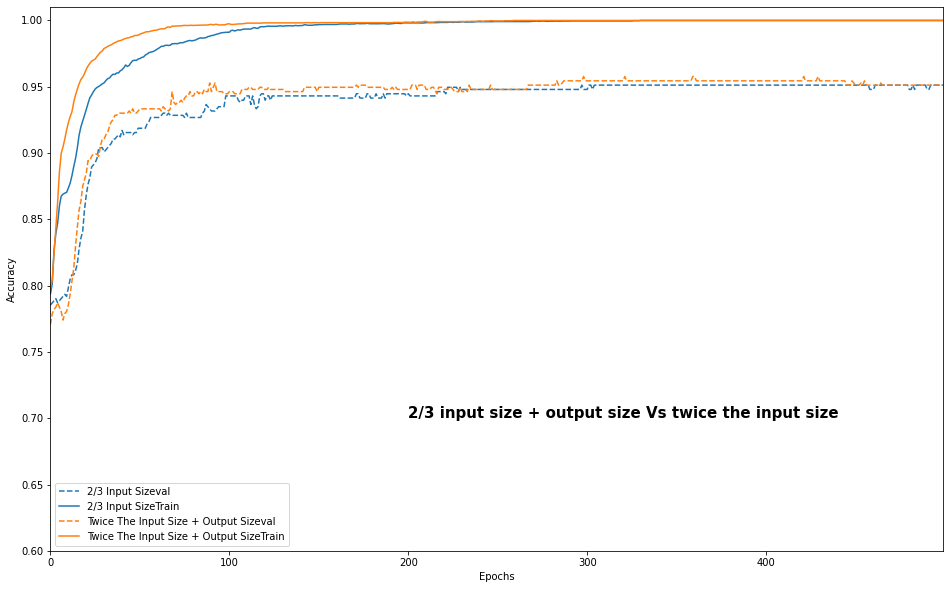

In [ ]:
plot_history([('2/3 input size', input2_history),('twice the input size + output size',input3_history)],'accuracy')
plt.annotate('2/3 input size + output size Vs twice the input size',xy=(200,0.7),weight='bold', fontsize=15)

 **Using Regularization methods**

In [ ]:
l1_model = keras.Sequential([
    keras.layers.Dense(8,  activation=tf.nn.relu,
                       input_shape=(x_train.shape[1],)),
    keras.layers.Dense(8, use_bias=True, kernel_regularizer=keras.regularizers.l1(0.001), activation=tf.nn.relu),
    keras.layers.Dense(8, use_bias=True, kernel_regularizer=keras.regularizers.l1(0.001), activation=tf.nn.relu),
    keras.layers.Dense(5, activation = tf.nn.softmax)
  ])

l1_model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=METRICS)

#l1_model.summary()
l1_history = l1_model.fit(x_train,y_train, epochs=EPOCHS,
                    validation_data= (x_test, y_test), verbose=0,
                    callbacks=[PrintDot()])
print('\n')
print(max(l1_history.history['val_accuracy']))


....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................

0.947967529296875


In [ ]:
l2_model = keras.Sequential([
    keras.layers.Dense(16, kernel_regularizer=keras.regularizers.l2(0.001), activation=tf.nn.relu,
                       input_shape=(x_train.shape[1],)),
    keras.layers.Dropout(0.25),
    keras.layers.Dense(10, kernel_regularizer=keras.regularizers.l2(0.001), activation=tf.nn.relu),
    keras.layers.Dropout(0.25),
    keras.layers.Dense(5, activation = tf.nn.softmax)
  ])
l2_model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=METRICS)

l2_history = l2_model.fit(x_train, y_train, epochs=EPOCHS,
                    validation_data= (x_test, y_test), verbose=0,
                    callbacks=[PrintDot()])
print('\n')
print(max(l2_history.history['val_accuracy']))


....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................

0.9707316756248474


In [ ]:
valpreds_l2 = l2_model.predict_on_batch(x_test)
y_pred_l2 = valpreds_l2.argmax(axis=1)
y_prrd_l2= pd.DataFrame(y_pred_l2,columns=["progress_l2"])
# y_test1 = y_test.argmax(axis=1)
# y_test1= pd.DataFrame(y_test1,columns=["progress"])
print(metrics.confusion_matrix(y_test1,y_prrd_l2))
print(metrics.classification_report(y_test1,y_prrd_l2))

[[93  0  3  0  0]
 [ 1  2  0  0  0]
 [ 0  0  6  2  1]
 [ 3  0  0  1  2]
 [ 0  0  0  1  8]]
              precision    recall  f1-score   support

           0       0.96      0.97      0.96        96
           1       1.00      0.67      0.80         3
           2       0.67      0.67      0.67         9
           3       0.25      0.17      0.20         6
           4       0.73      0.89      0.80         9

    accuracy                           0.89       123
   macro avg       0.72      0.67      0.69       123
weighted avg       0.89      0.89      0.89       123



In [ ]:
print(max(l1_history.history['val_recall']))
print(max(l2_history.history['val_recall']))


0.8536585569381714
0.9186992049217224


Text(100, 0.7, 'Different regularization models Comparision')

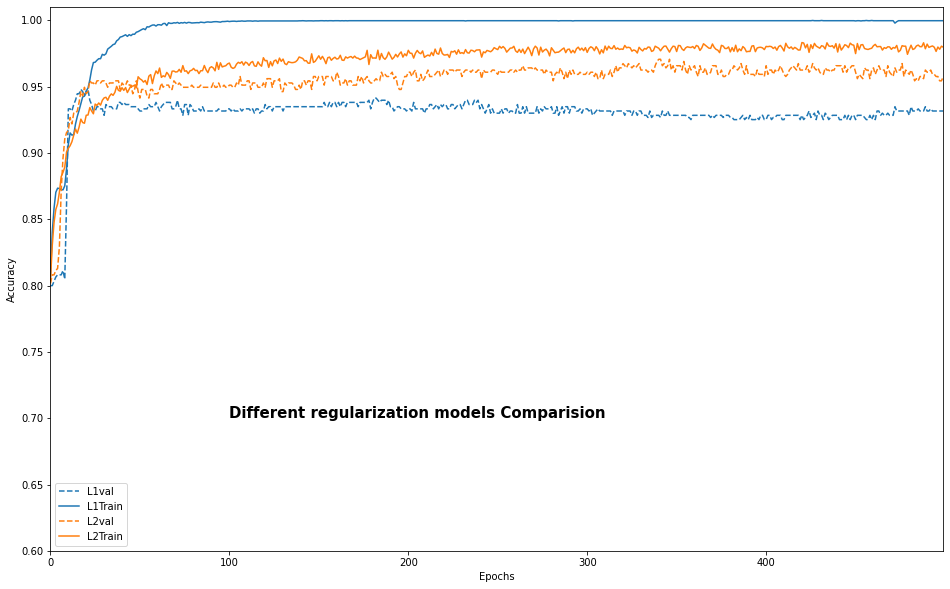

In [ ]:
plot_history([('L1',l1_history),('L2',l2_history)],'accuracy')
plt.annotate('Different regularization models Comparision',xy=(100,0.7),weight='bold', fontsize=15)

RELU and  other activation function

In [ ]:
activation_model = keras.Sequential([
    keras.layers.Dense(8, activation=tf.nn.relu,
                       input_shape=(x_train.shape[1],)),
    keras.layers.Dense(8, activation='linear'),

    keras.layers.Dense(5, activation = tf.nn.softmax)

  ])

activation_model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=METRICS)

activation_model.summary()
activation_history = activation_model.fit(x_train, y_train, epochs=EPOCHS,batch_size=128,
                    validation_data= (x_test, y_test), verbose=0,
                    callbacks=[PrintDot()])
print('\n')
print(max(activation_history.history['val_accuracy']))

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_16 (Dense)             (None, 8)                 112       
_________________________________________________________________
dense_17 (Dense)             (None, 8)                 72        
_________________________________________________________________
dense_18 (Dense)             (None, 5)                 45        
Total params: 229
Trainable params: 229
Non-trainable params: 0
_________________________________________________________________

....................................................................................................
....................................................................................................
....................................................................................................
..................................................................................

In [ ]:
print(max(activation_history.history['val_recall']))
print(max(hidden2_history.history['val_recall']))


0.8780487775802612
0.8455284833908081


Text(100, 0.7, 'Different activation models Comparision')

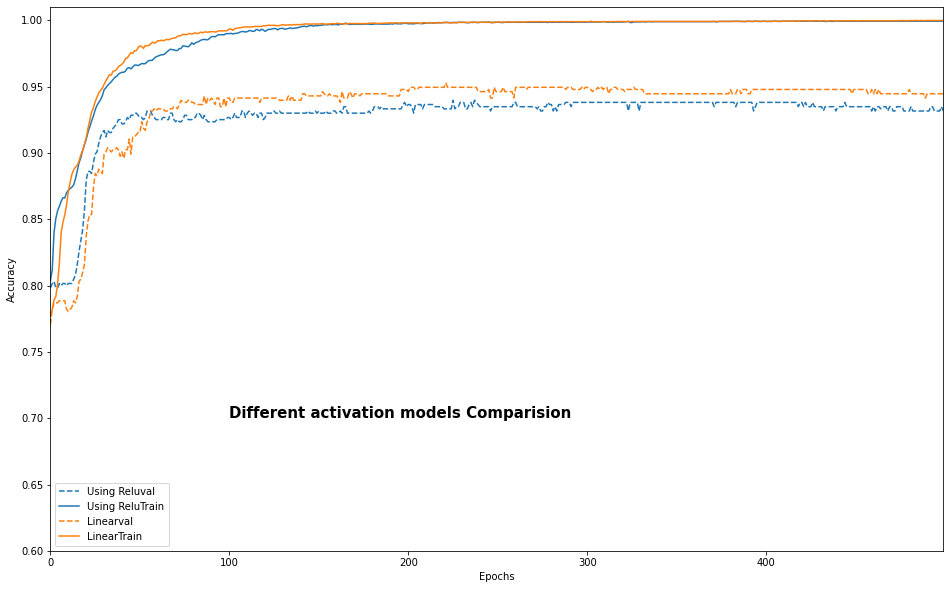

In [ ]:
plot_history([('using RELU',hidden2_history),('linear',activation_history)],'accuracy')
plt.annotate('Different activation models Comparision',xy=(100,0.7),weight='bold', fontsize=15)

#Comparision of models trained using different regularization techniques
1. As the models trained without regualrization by increasing capacity resulted in more generalization error , thus resulted in overfitting.Instead of learning the patern, they seems to be memorizing data.
2. So, applied the l1_regularization, l2_regularization for training model. The model using l2_regularization is performing better when compared the model with l1_regularization. As we know that l1_regularization may result in parsimonous models dropping some features but as the number of features in dataset are only 13 so, l1_regularization resulted in slightly low  accuracy 94.7,recall 85.3
3. So trained another model using l2_regularization  which will penalize as the capacity increases. So, the model using l2_regularization has captured the complexity underlying the model at the same time penalizing it and resulted with accuarcy 97.07, recall 91.86.
4. So, in comparision of models trained using different regularization techniques, the model with l2_regularization performed better when compared to model with l1_regularization.


#**Final best Model**

1. Of all the models , the model trained using l2_regularization, with 2 Hidden layers , activation function RELU,Softmax is performing better than all other models.The different metrics of L2_regularization model:
        Accuracy:97.07
        Reca11  :91.8
        Predicted the reocrds of all the classes in the label.


